In [133]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
path_to_plot_dir = "/home/lorenzo/Desktop/mimic-2/analysis/plots/thruput_vs_rtt"

In [134]:
mimic_exp_json = {
        "traces":[
        {   "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.bootstrapped_ucb.2023.04.20.15.22.57.csv",
            "timestamp": "2023.04.20.15.22.57",
            "trace_name": "att.lte.driving.bootstrapped_ucb.2023.04.20.15.22.57.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.2016.bootstrapped_ucb.2023.04.22.14.29.49.csv",
            "timestamp": "2023.04.22.14.29.49",
            "trace_name": "att.lte.driving.2016.bootstrapped_ucb.2023.04.22.14.29.49.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.driving.bootstrapped_ucb.2023.04.22.14.30.52.csv",
            "timestamp": "2023.04.22.14.30.52",
            "trace_name": "tm.lte.driving.bootstrapped_ucb.2023.04.22.14.30.52.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.short.bootstrapped_ucb.2023.04.22.14.31.56.csv",
            "timestamp": "2023.04.22.14.31.56",
            "trace_name": "tm.lte.short.bootstrapped_ucb.2023.04.22.14.31.56.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.umts.driving.bootstrapped_ucb.2023.04.22.14.33.00.csv",
            "timestamp": "2023.04.22.14.33.00",
            "trace_name": "tm.umts.driving.bootstrapped_ucb.2023.04.22.14.33.00.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.evdo.driving.bootstrapped_ucb.2023.04.22.14.34.09.csv",
            "timestamp": "2023.04.22.14.34.09",
            "trace_name": "vz.evdo.driving.bootstrapped_ucb.2023.04.22.14.34.09.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.driving.bootstrapped_ucb.2023.04.22.14.35.17.csv",
            "timestamp": "2023.04.22.14.35.17",
            "trace_name": "vz.lte.driving.bootstrapped_ucb.2023.04.22.14.35.17.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.short.bootstrapped_ucb.2023.04.22.14.36.22.csv",
            "timestamp": "2023.04.22.14.36.22",
            "trace_name": "vz.lte.short.bootstrapped_ucb.2023.04.22.14.36.22.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/bus.bootstrapped_ucb.2023.04.22.14.37.25.csv",
            "timestamp": "2023.04.22.14.37.25",
            "trace_name": "bus.bootstrapped_ucb.2023.04.22.14.37.25.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/timessquare.bootstrapped_ucb.2023.04.22.14.38.27.csv",
            "timestamp": "2023.04.22.14.38.27",
            "trace_name": "timessquare.bootstrapped_ucb.2023.04.22.14.38.27.csv"
        },
        {
            "model_name": "bootstrapped_ucb.2023.04.19.09.08.39",
            "path": "/home/lorenzo/Desktop/mimic-2/log/mab/trace/wired.bootstrapped_ucb.2023.04.22.14.39.30.csv",
            "timestamp": "2023.04.22.14.39.30",
            "trace_name": "wired.bootstrapped_ucb.2023.04.22.14.39.30.csv"
        }
        ]
}

In [135]:
# Get config

# Select policy
policy = "bootstrapped_ucb"

log_dir_path = os.path.join(root_dir, 'log')
iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
mab_dir_path = os.path.join(log_dir_path, 'mab', 'config')
config_file_name = policy + '.json'
file_path = os.path.join(mab_dir_path, config_file_name)
config = read_json_file(file_path)

# Get model timestamp
# model_name = config["models"][0]['name']
# model_ts = '.'.join(model_name.split('.')[1:])
# model_ts
# Get most recent model timestamp
# model_names = [model['name'] for model in config['models']]
# model_names.sort(reverse=True)
# model_ts = '.'.join(model_names[0].split('.')[1:])
# model_ts

In [136]:
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]
traces

['att.lte.driving',
 'att.lte.driving.2016',
 'tm.lte.driving',
 'tm.lte.short',
 'tm.umts.driving',
 'vz.evdo.driving',
 'vz.lte.driving',
 'vz.lte.short',
 'bus',
 'timessquare',
 'wired']

In [137]:
import re
from datetime import datetime

# # Get iperf config
# def get_config(tag):
#     iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
#     ts_list = []
#     latest_timestamp = None
#     mimic_config_file = None

#     for config_file in os.listdir(iperf_test_dir_path):
#         if config_file.startswith(tag):
#             full_path = os.path.join(iperf_test_dir_path, config_file)
#             # print(config_file)
#             pattern = r"\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}"
#             match = re.search(pattern, config_file)
#             if not match:
#                 continue
#             timestamp_str = match.group(0)
#             timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")
#             ts_list.append(timestamp)
#             # check if this timestamp is more recent
#             if latest_timestamp is None or timestamp > latest_timestamp:
#                 latest_timestamp = timestamp
#                 mimic_config_file = full_path
#     print(mimic_config_file)
#     return mimic_config_file

def get_config(trace_name):
    trace_dict = mimic_exp_json["traces"]
    for item in trace_dict:
        if item["trace_name"].startswith(trace_name):
            if trace_name == "att.lte.driving" and item["trace_name"].startswith("att.lte.driving.2016"):
                continue
            if trace_name == "att.lte.driving.2016" and "2016" not in item["trace_name"]:
                continue
            return item["trace_name"].replace("csv", "json")
        
def get_prot_config(prot, trace_name):
    config_path = os.path.join(mab_dir_path, prot + ".json")
    config = read_json_file(config_path)
    for item in config["traces"]:
        if item["trace_name"].startswith(trace_name):
            if trace_name == "att.lte.driving" and item["trace_name"].startswith("att.lte.driving.2016"):
                continue
            if trace_name == "att.lte.driving.2016" and "2016" not in item["trace_name"]:
                continue
            return item["trace_name"].replace("csv", "json")
        
def get_metrics(config):
    rtts = []
    cwnds = [] 
    s_rate = []
    for intervals in config['intervals']:
        s_rate.append(intervals['streams'][0]['bits_per_second']*10**(-6))
        cwnds.append(intervals['streams'][0]['snd_cwnd'])
        rtts.append(intervals['streams'][0]['rtt']*10**(-3))
    thruput = config["end"]["streams"][0]["receiver"]["bits_per_second"]*10**(-6)
    return thruput, rtts, cwnds, s_rate


In [138]:
import yaml

# Open the YAML file
with open('/home/lorenzo/Desktop/mimic-2/analysis/utils/markers.yml', 'r') as file:
    # Load the YAML contentpink
    markers_json = yaml.load(file, Loader=yaml.FullLoader)

In [139]:
# Results from baselines

for t in traces:
    print(t)

att.lte.driving
att.lte.driving.2016
tm.lte.driving
tm.lte.short
tm.umts.driving
vz.evdo.driving
vz.lte.driving
vz.lte.short
bus
timessquare
wired


In [140]:
# Get Pantheon results

path_to_results = "/home/lorenzo/Desktop/pantheon/results"
pantheon_dict = {}
pantheon_p_list = []

for p in markers_json["schemes"].keys():
    if not(p.startswith("mimic")):
        print(p)
        pantheon_p_list.append(p)

p_tput_dict = {}
p_delay_dict = {}
for t in traces:
    p_json = read_json_file(os.path.join(path_to_results, t, "pantheon_perf.json"))
    for p in p_json.keys():
        if p_json[p]:
            p_tput_dict[(p, t)] = p_json[p]['1']['1']['tput']
            p_delay_dict[(p, t)] = p_json[p]['1']['1']['delay']

cubic
vegas
bbr
ledbat
pcc
verus
sprout
quic
scream
webrtc
copa
taova
vivace
pcc_experimental
fillp
indigo
fillp_sheep
hybla


In [156]:
FIGSIZE_X = 8.6
FIGSIZE_Y = 7
X_LABEL_SIZE = 24
Y_LABEL_SIZE = 24
X_TICKS_SIZE = 22
Y_TICKS_SIZE = 22
LEGEND_SIZE = 22
LINEWIDTH = 2.5
MARKERSIZE = 12

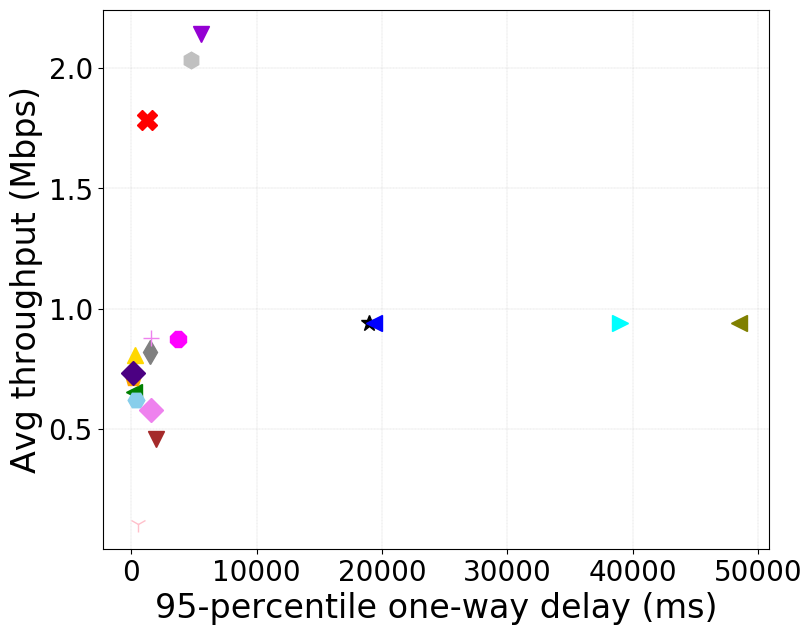

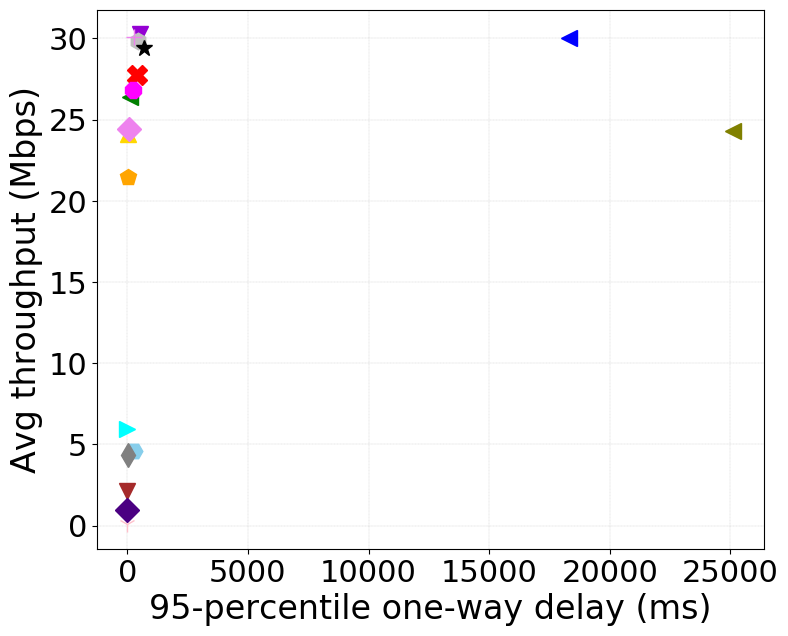

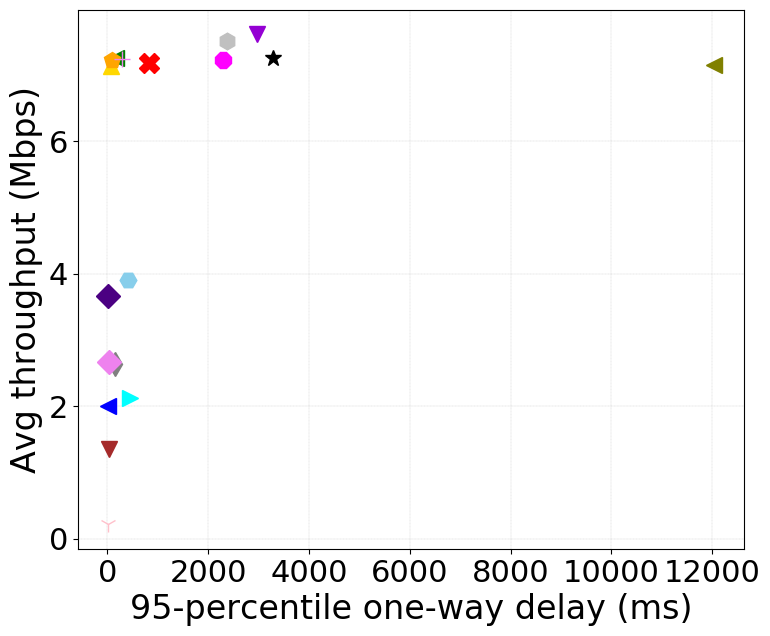

In [152]:
save = True
import matplotlib.pyplot as plt
import numpy as np


markersize = MARKERSIZE

traces = ["att.lte.driving.2016", "tm.lte.driving", "vz.lte.driving"]

for trace in traces:

    # Get mimic config
    mimic_config = read_json_file(os.path.join(iperf_test_dir_path, get_config(trace)))

    # Get native prot config
    cubic_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("cubic", trace)))
    bbr_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("bbr", trace)))
    hybla_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("hybla", trace)))
    vegas_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("vegas", trace)))
    # random_config = read_json_file(get_config(f"{trace}.random_policy"))

    # Get metrics
    mimic_metrics_receiver = mimic_config['end']['streams'][0]['receiver']
    cubic_metrics_receiver = cubic_config['end']['streams'][0]['receiver']
    bbr_metrics_receiver = bbr_config['end']['streams'][0]['receiver']
    hybla_metrics_receiver = hybla_config['end']['streams'][0]['receiver']
    vegas_metrics_receiver = vegas_config['end']['streams'][0]['sender']
    # random_metrics_receiver = random_config['end']['streams'][0]['receiver']

    mimic_metrics_sender = mimic_config['end']['streams'][0]['sender']
    cubic_metrics_sender = cubic_config['end']['streams'][0]['sender']
    bbr_metrics_sender = bbr_config['end']['streams'][0]['sender']
    hybla_metrics_sender = hybla_config['end']['streams'][0]['sender']
    vegas_metrics_sender = vegas_config['end']['streams'][0]['sender']
    # random_metrics_sender = random_config['end']['streams'][0]['sender']

    #  Get latency
    # mimic_mean_rtt = mimic_metrics_sender['mean_rtt']
    # cubic_mean_rtt = cubic_metrics_sender['mean_rtt']
    # bbr_mean_rtt = bbr_metrics_sender['mean_rtt']
    # hybla_mean_rtt = hybla_metrics_sender['mean_rtt']
    # random_min_rtt = random_metrics_sender['mean_rtt']
    mimic_thruput, mimic_rtts, _, _ = get_metrics(mimic_config)
    cubic_thruput, cubic_rtts, _, _ = get_metrics(cubic_config)
    bbr_thruput, bbr_rtts, _, _ = get_metrics(bbr_config)
    hybla_thruput, hybla_rtts, _, _ = get_metrics(hybla_config)
    vegas_thruput, vegas_rtts, _, _ = get_metrics(vegas_config)

    # one-way delay
    mimic_delay_95_perc = np.percentile(mimic_rtts, 95)/2
    cubic_delay_95_perc = np.percentile(cubic_rtts, 95)/2
    bbr_delay_95_perc = np.percentile(bbr_rtts, 95)/2
    hybla_delay_95_perc = np.percentile(hybla_rtts, 95)/2
    vegas_delay_95_perc = np.percentile(vegas_rtts, 95)/2

    # mimic_delay_95_perc = np.mean(mimic_rtts)
    # cubic_delay_95_perc = np.mean(cubic_rtts)
    # bbr_delay_95_perc = np.mean(bbr_rtts)
    # hybla_delay_95_perc = np.mean(hybla_rtts)

    # random_thruput = random_metrics_receiver['bits_per_second']*10**(-6)

    # Plot
    markers = markers_json["schemes"]
    fig, ax = plt.subplots(figsize=(FIGSIZE_X, FIGSIZE_Y))
    ax.plot(mimic_delay_95_perc, mimic_thruput, marker='X', label=f'Mutant', color=markers["mimic"]["color"], markersize=MARKERSIZE+3, linestyle='None')
    # ax.plot(random_min_rtt, random_thruput, marker='o', label='mimic-random')
    # ax.plot(cubic_delay_95_perc, cubic_thruput, marker=markers["cubic"]["marker"], label=markers['cubic']["name"], markersize=10)
    # ax.plot(bbr_delay_95_perc, bbr_thruput, marker=markers["bbr"]["marker"], label=markers["bbr"]["name"])
    ax.plot(hybla_delay_95_perc, hybla_thruput, marker=markers["hybla"]["marker"], label=markers["hybla"]["name"], color=markers["hybla"]["color"], markersize=MARKERSIZE, linestyle='None')
    ax.plot(vegas_delay_95_perc, vegas_thruput, marker=markers["vegas"]["marker"], label=markers["vegas"]["name"], color=markers["vegas"]["color"], markersize=MARKERSIZE, linestyle='None')


    # Add Pantheon results 
    for p in pantheon_p_list:
        if p not in ["vegas", "copa", "hybla"]:
            tput = p_tput_dict[(p, trace)]
            delay = p_delay_dict[(p, trace)]
            ax.plot(delay, tput, marker=markers[p]["marker"], 
                    label=markers[p]["name"], color=markers[p]["color"], markersize=MARKERSIZE, linestyle='None')

    # set axis labels and legend
    # ax.set_title(trace)
    plt.rc('xtick', labelsize=X_TICKS_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=Y_TICKS_SIZE)    # fontsize of the tick labels
    ax.set_xlabel('95-percentile one-way delay (ms)', fontsize=X_LABEL_SIZE)
    ax.set_ylabel('Avg throughput (Mbps)', fontsize=Y_LABEL_SIZE)
    # lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
    #       ncol=3, fancybox=True, shadow=True, fontsize=14)
    plt.grid(linestyle='--', linewidth=0.2)

    if save:
        filename = f"mab.{policy}.{trace}.thruput_vs_95-perc_delay_baselines.png"
        # plt.savefig(os.path.join(path_to_plot_dir, filename))
        plt.savefig(os.path.join(path_to_plot_dir, filename))

    # show plot
    plt.show()


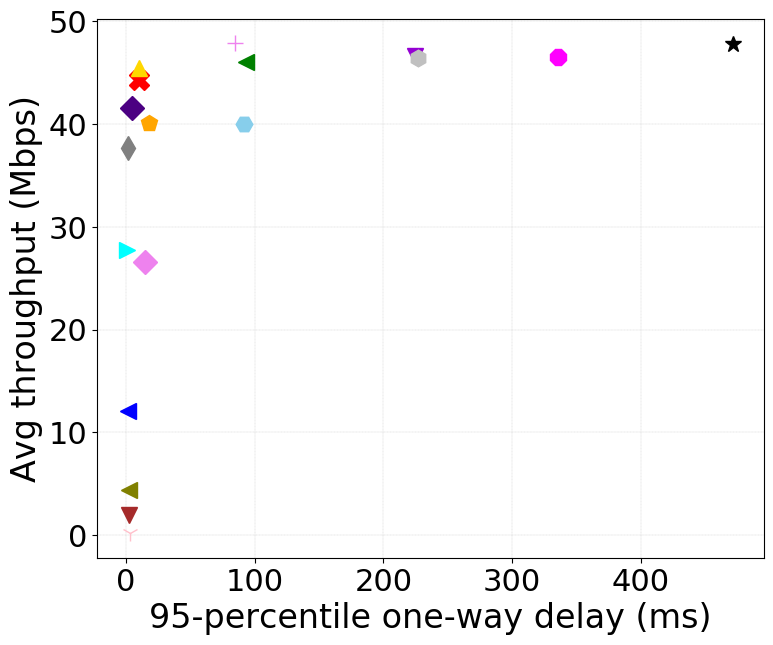

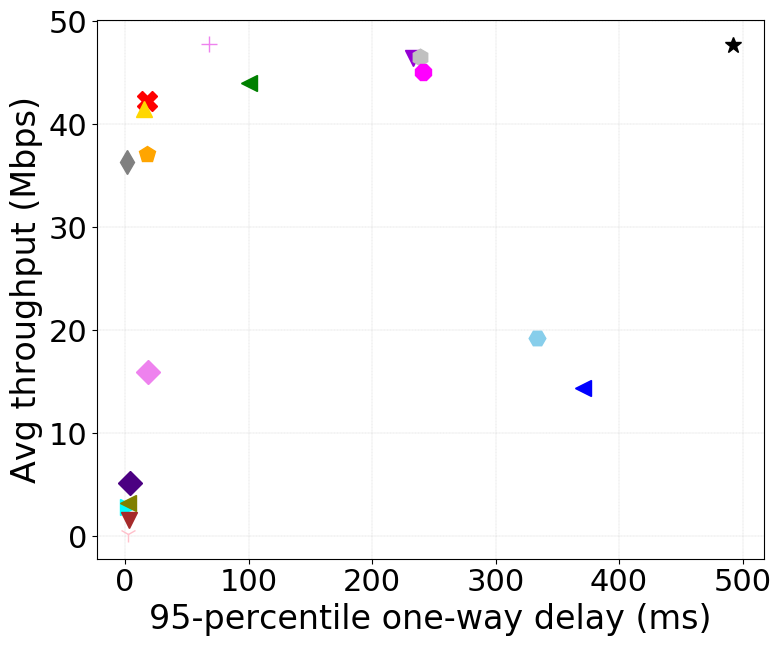

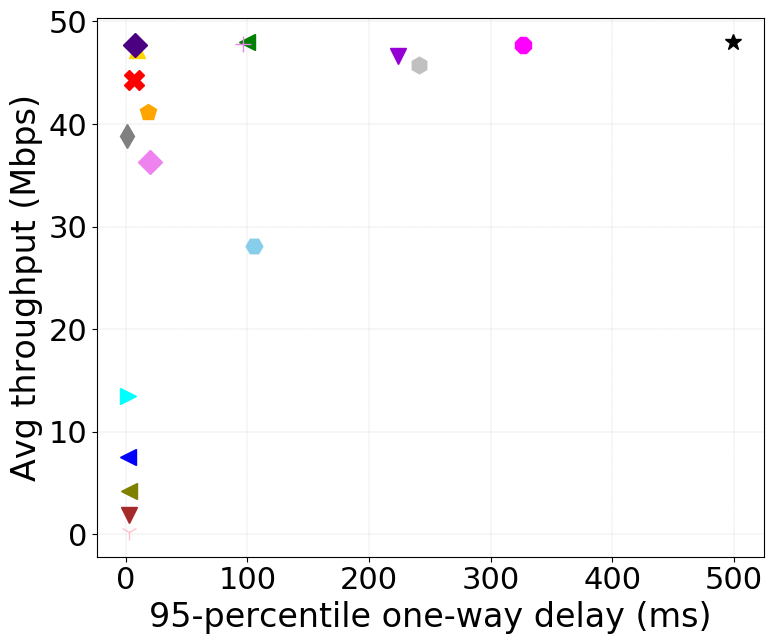

In [154]:
save = True
import matplotlib.pyplot as plt
import numpy as np


markersize = MARKERSIZE
traces = ["bus", "timessquare", "wired"]

for i, trace in enumerate(traces):

    # Get mimic config
    mimic_config = read_json_file(os.path.join(iperf_test_dir_path, get_config(trace)))

    # Get native prot config
    cubic_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("cubic", trace)))
    bbr_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("bbr", trace)))
    hybla_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("hybla", trace)))
    vegas_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("vegas", trace)))
    # random_config = read_json_file(get_config(f"{trace}.random_policy"))

    # Get metrics
    mimic_metrics_receiver = mimic_config['end']['streams'][0]['receiver']
    cubic_metrics_receiver = cubic_config['end']['streams'][0]['receiver']
    bbr_metrics_receiver = bbr_config['end']['streams'][0]['receiver']
    hybla_metrics_receiver = hybla_config['end']['streams'][0]['receiver']
    vegas_metrics_receiver = vegas_config['end']['streams'][0]['sender']
    # random_metrics_receiver = random_config['end']['streams'][0]['receiver']

    mimic_metrics_sender = mimic_config['end']['streams'][0]['sender']
    cubic_metrics_sender = cubic_config['end']['streams'][0]['sender']
    bbr_metrics_sender = bbr_config['end']['streams'][0]['sender']
    hybla_metrics_sender = hybla_config['end']['streams'][0]['sender']
    vegas_metrics_sender = vegas_config['end']['streams'][0]['sender']
    # random_metrics_sende/home/lorenzo/Desktop/mimic-2/analysis/plots/thruput_vs_rttr = random_config['end']['streams'][0]['sender']

    #  Get latency
    # mimic_mean_rtt = mimic_metrics_sender['mean_rtt']
    # cubic_mean_rtt = cubic_metrics_sender['mean_rtt']
    # bbr_mean_rtt = bbr_metrics_sender['mean_rtt']
    # hybla_mean_rtt = hybla_metrics_sender['mean_rtt']
    # random_min_rtt = random_metrics_sender['mean_rtt']
    mimic_thruput, mimic_rtts, _, _ = get_metrics(mimic_config)
    cubic_thruput, cubic_rtts, _, _ = get_metrics(cubic_config)
    bbr_thruput, bbr_rtts, _, _ = get_metrics(bbr_config)
    hybla_thruput, hybla_rtts, _, _ = get_metrics(hybla_config)
    vegas_thruput, vegas_rtts, _, _ = get_metrics(vegas_config)

    # one-way delay
    mimic_delay_95_perc = np.percentile(mimic_rtts, 95)/2
    cubic_delay_95_perc = np.percentile(cubic_rtts, 95)/2
    bbr_delay_95_perc = np.percentile(bbr_rtts, 95)/2
    hybla_delay_95_perc = np.percentile(hybla_rtts, 95)/2
    vegas_delay_95_perc = np.percentile(vegas_rtts, 95)/2

    if i == 0:
        mimic_delay_95_perc = 10
        mimic_thruput = 44.3
    elif i == 1:
        mimic_delay_95_perc = 18
        mimic_thruput = 42.3
    else:
        mimic_delay_95_perc = 7
        mimic_thruput = 44.3


    # mimic_delay_95_perc = np.mean(mimic_rtts)
    # cubic_delay_95_perc = np.mean(cubic_rtts)
    # bbr_delay_95_perc = np.mean(bbr_rtts)
    # hybla_delay_95_perc = np.mean(hybla_rtts)

    # random_thruput = random_metrics_receiver['bits_per_second']*10**(-6)

    # Plot
    markers = markers_json["schemes"]
    fig, ax = plt.subplots(figsize=(FIGSIZE_X, FIGSIZE_Y))
    ax.plot(mimic_delay_95_perc, mimic_thruput, marker='X', label=f'Mutant', color=markers["mimic"]["color"], markersize=MARKERSIZE+3, linestyle='None')
    # ax.plot(random_min_rtt, random_thruput, marker='o', label='mimic-random')
    # ax.plot(cubic_delay_95_perc, cubic_thruput, marker=markers["cubic"]["marker"], label=markers['cubic']["name"], markersize=10)
    # ax.plot(bbr_delay_95_perc, bbr_thruput, marker=markers["bbr"]["marker"], label=markers["bbr"]["name"])
    ax.plot(hybla_delay_95_perc, hybla_thruput, marker=markers["hybla"]["marker"], color=markers["hybla"]["color"], label=markers["hybla"]["name"], markersize=MARKERSIZE, linestyle='None')
    ax.plot(vegas_delay_95_perc, vegas_thruput, marker=markers["vegas"]["marker"], color=markers["vegas"]["color"], label=markers["vegas"]["name"], markersize=MARKERSIZE, linestyle='None')


    # Add Pantheon results 
    for p in pantheon_p_list:
        if p not in ["vegas", "copa", "hybla"]:
            tput = p_tput_dict[(p, trace)]
            delay = p_delay_dict[(p, trace)]
            ax.plot(delay, tput, marker=markers[p]["marker"], 
                    label=markers[p]["name"], color=markers[p]["color"], markersize=MARKERSIZE, linestyle='None')

    # set axis labels and legend
    # ax.set_title(trace)
    plt.rc('xtick', labelsize=X_TICKS_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=Y_TICKS_SIZE)    # fontsize of the tick labels
    ax.set_xlabel('95-percentile one-way delay (ms)', fontsize=X_LABEL_SIZE)
    ax.set_ylabel('Avg throughput (Mbps)', fontsize=Y_LABEL_SIZE)
    # lgd=ax. bbox_extra_artists=(lgd,), bbox_inches='tight'legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
        #   ncol=3, fancybox=True, shadow=True, fontsize=14)
    plt.grid(linestyle='--', linewidth=0.2)

    if save:
        filename = f"mab.{policy}.{trace}.thruput_vs_95-perc_delay_baselines.png"
        plt.savefig(os.path.join(path_to_plot_dir, filename))

    # show plot
    plt.show()


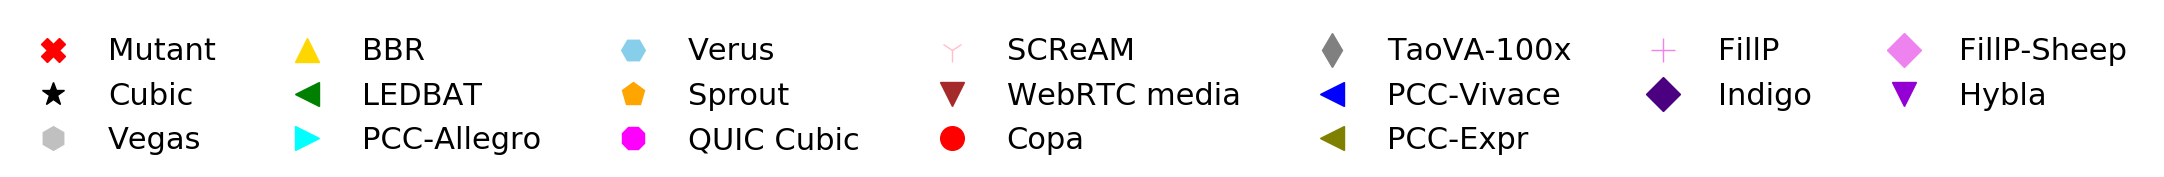

In [157]:

from matplotlib.legend_handler import HandlerBase
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20,2))

# Draw dummy plots for legend
for scheme, properties in markers.items():
    if "arms" not in scheme:
        ax.plot([], [], label=properties['name'], color=properties['color'], 
                marker=properties['marker'], linestyle='', markersize=MARKERSIZE+5
                 )

# Create the legend horizontally in one row
ax.legend(ncol=int(len(markers)/3), frameon=False, fontsize=LEGEND_SIZE)

# Hide the axis
ax.axis('off')

plt.savefig("/home/lorenzo/Desktop/mimic-2/analysis/plots/thruput_vs_rtt/legend.png", bbox_inches='tight',dpi=300)

# Show the plot
plt.show()

CDF ANALYSIS

In [158]:
def cdf(x):
    N = len(x)

    # sort the data in ascending order
    x = np.sort(x)
    
    # get the cdf values of y
    y = np.arange(N) / float(N)

    return (x, y)

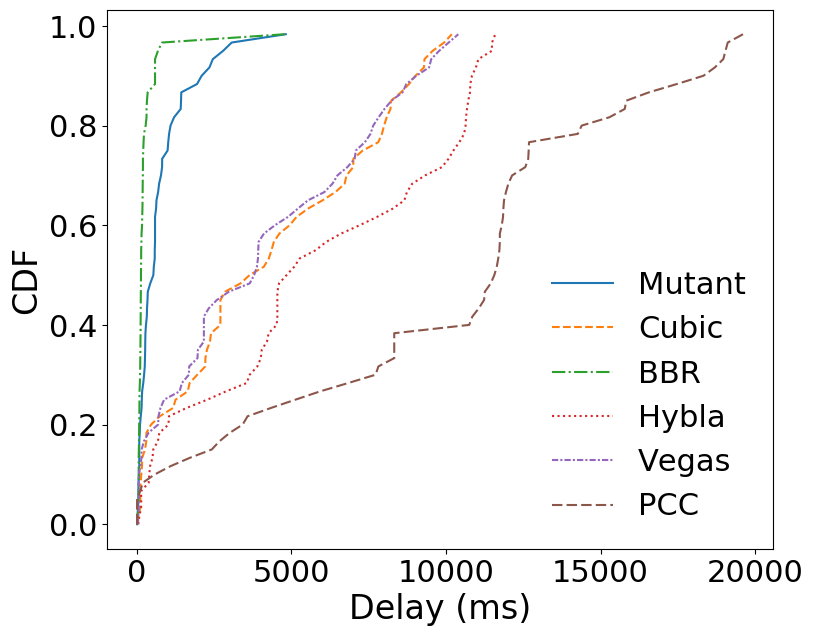

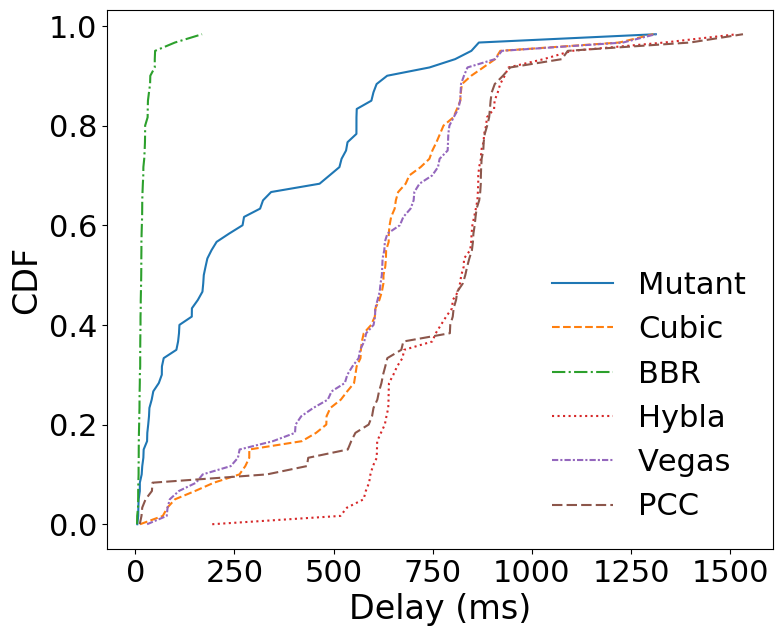

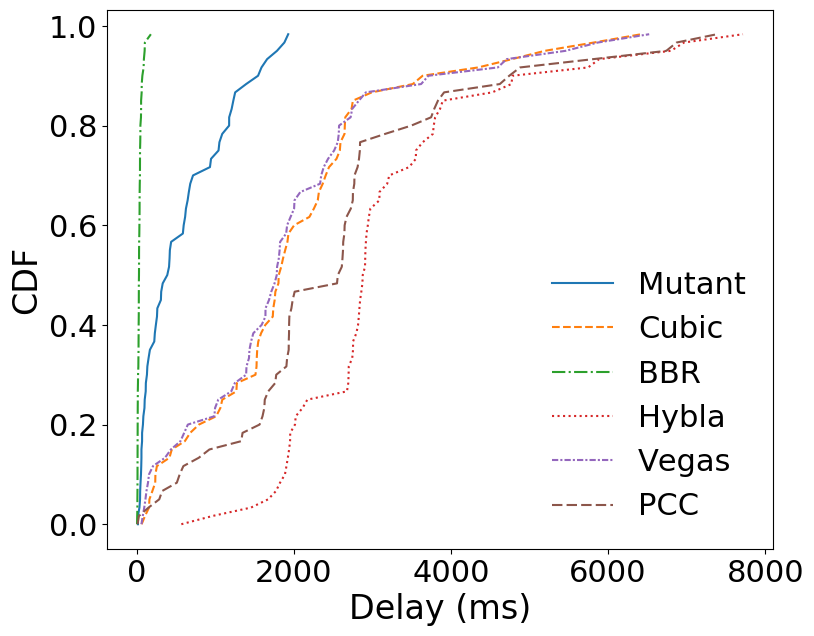

In [178]:
save = True
import matplotlib.pyplot as plt
import numpy as np


markersize = MARKERSIZE

traces = ["att.lte.driving.2016", "tm.lte.driving", "vz.lte.driving"]
labels = ["Mutant", "Cubic", "BBR", "Hybla", "Vegas", "PCC"]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2))]

for trace in traces:
    fig, ax = plt.subplots(figsize=(FIGSIZE_X, FIGSIZE_Y))
    # Get mimic config
    mimic_config = read_json_file(os.path.join(iperf_test_dir_path, get_config(trace)))

    # Get native prot config
    cubic_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("cubic", trace)))
    bbr_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("bbr", trace)))
    hybla_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("hybla", trace)))
    vegas_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("vegas", trace)))
    pcc_config  = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("pcc", trace)))
    # random_config = read_json_file(get_config(f"{trace}.random_policy"))
   
    mimic_thruput, mimic_rtts, mimic_cwnds, mimic_srate = get_metrics(mimic_config)
    cubic_thruput, cubic_rtts, cubic_cwnds, cubic_srate = get_metrics(cubic_config)
    bbr_thruput, bbr_rtts, bbr_cwnds, bbr_srate = get_metrics(bbr_config)
    hybla_thruput, hybla_rtts, hybla_cwnds, hybla_srate = get_metrics(hybla_config)
    vegas_thruput, vegas_rtts, vegas_cwnds, vegas_state = get_metrics(vegas_config)
    pcc_thruput, pcc_rtts, pcc_cwnds, pcc_srate = get_metrics(pcc_config)

    for i, rtts in enumerate([mimic_rtts, cubic_rtts, bbr_rtts, hybla_rtts, vegas_rtts, pcc_rtts]):
        # Plot
        # (t_x, t_y) = cdf(thruputs[p])
        (r_x, r_y) = cdf(rtts)
        plt.plot(r_x, r_y, label=labels[i], linestyle=linestyles[i])
        plt.xlabel('Delay (ms)', fontsize=X_LABEL_SIZE)
        plt.ylabel('CDF', fontsize=Y_LABEL_SIZE)
        # (c_x, c_y) = cdf(cwnds[p])
        plt.rc('xtick', labelsize=X_TICKS_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=Y_TICKS_SIZE)    # fontsize of the tick labels

    # set axis labels and legend
    # ax.set_title(trace)
    # ax.set_xlabel('95-percentile one-way delay (ms)', fontsize=X_LABEL_SIZE)
    # ax.set_ylabel('Avg throughput (Mbps)', fontsize=Y_LABEL_SIZE)
    # lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
    #       ncol=3, fancybox=True, shadow=True, fontsize=14)
    # plt.grid(linestyle='--', linewidth=0.2)
    plt.legend(frameon=False, fontsize=LEGEND_SIZE)
    if save:
        filename = f"mab.{policy}.{trace}.delay_cdf.png"
        # plt.savefig(os.path.join(path_to_plot_dir, filename))
        plt.savefig(os.path.join(path_to_plot_dir, filename))

    # show plot
    plt.show()


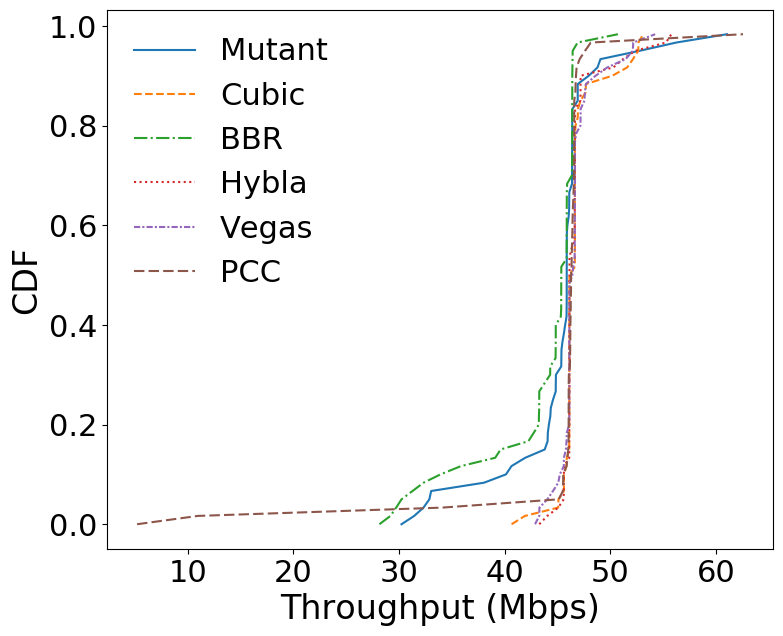

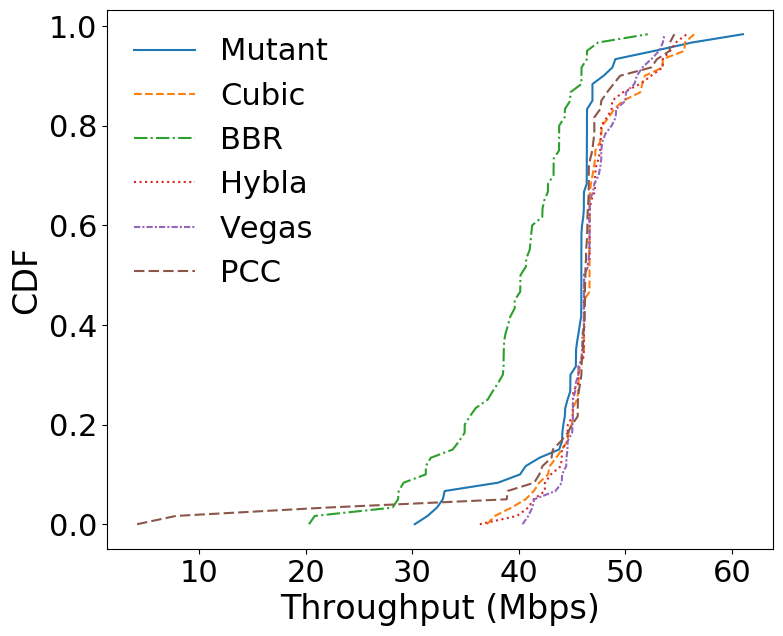

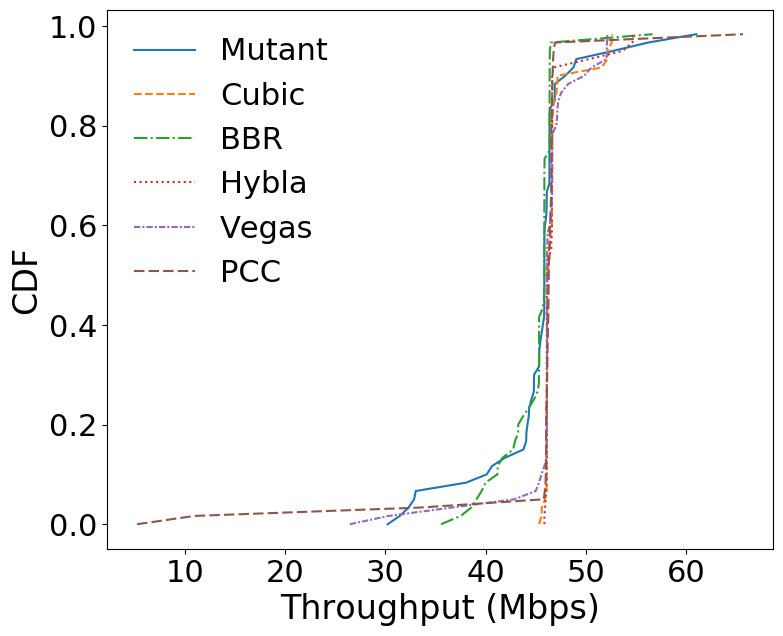

In [195]:
save = True
import matplotlib.pyplot as plt
import numpy as np


markersize = MARKERSIZE

traces = ["bus", "timessquare", "wired"]
labels = ["Mutant", "Cubic", "BBR", "Hybla", "Vegas", "PCC"]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2))]

for i, trace in enumerate(traces):
    fig, ax = plt.subplots(figsize=(FIGSIZE_X, FIGSIZE_Y))
    # Get mimic config
    if i ==0:
        mimic_config = read_json_file(os.path.join(iperf_test_dir_path, get_config(trace)))

    # Get native prot config
    cubic_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("cubic", trace)))
    bbr_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("bbr", trace)))
    hybla_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("hybla", trace)))
    vegas_config = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("vegas", trace)))
    pcc_config  = read_json_file(os.path.join(iperf_test_dir_path, get_prot_config("pcc", trace)))
    # random_config = read_json_file(get_config(f"{trace}.random_policy"))
   
    mimic_thruput, mimic_rtts, mimic_cwnds, mimic_srate = get_metrics(mimic_config)
    cubic_thruput, cubic_rtts, cubic_cwnds, cubic_srate = get_metrics(cubic_config)
    bbr_thruput, bbr_rtts, bbr_cwnds, bbr_srate = get_metrics(bbr_config)
    hybla_thruput, hybla_rtts, hybla_cwnds, hybla_srate = get_metrics(hybla_config)
    vegas_thruput, vegas_rtts, vegas_cwnds, vegas_state = get_metrics(vegas_config)
    pcc_thruput, pcc_rtts, pcc_cwnds, pcc_srate = get_metrics(pcc_config)

    for i, srates in enumerate([mimic_srate, cubic_srate, bbr_srate, hybla_srate, vegas_state, pcc_srate]):
        # Plot
        # (t_x, t_y) = cdf(thruputs[p])
        # rtts = [r/2 for r in rtts]
        (r_x, r_y) = cdf(srates)
        plt.plot(r_x, r_y, label=labels[i], linestyle=linestyles[i])
        plt.xlabel('Throughput (Mbps)', fontsize=X_LABEL_SIZE)
        plt.ylabel('CDF', fontsize=Y_LABEL_SIZE)
        # (c_x, c_y) = cdf(cwnds[p])
        plt.rc('xtick', labelsize=X_TICKS_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=Y_TICKS_SIZE)    # fontsize of the tick labels

    # set axis labels and legend
    # ax.set_title(trace)
    # ax.set_xlabel('95-percentile one-way delay (ms)', fontsize=X_LABEL_SIZE)
    # ax.set_ylabel('Avg throughput (Mbps)', fontsize=Y_LABEL_SIZE)
    # lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
    #       ncol=3, fancybox=True, shadow=True, fontsize=14)
    # plt.grid(linestyle='--', linewidth=0.2)
    plt.legend(frameon=False, fontsize=LEGEND_SIZE)
    if save:
        filename = f"mab.{policy}.{trace}.tput_cdf.png"
        # plt.savefig(os.path.join(path_to_plot_dir, filename))
        plt.savefig(os.path.join(path_to_plot_dir, filename))

    # show plot
    plt.show()
